# Disease Risk Prediction Initial Program (Including CKD & Diabetes)

This model uses logistic regression, random forest, XGBoost and SVM to predict CKD. We will perform data cleaning, feature selection, class imbalance handling, and model evaluation.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import joblib
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8') # Plot style

## Step 1. Data Loading

In [2]:
print("--- Step 1. Data Loading ---")
df = pd.read_csv('ckd.csv')
print(f"Data Shape: {df.shape}")
df.head()

--- Step 1. Data Loading ---
Data Shape: (400, 25)


,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


## Step 2. Data Cleaning

Handle anomalies in the target variable, correct irregular characters, and convert categorical columns into numerical format.

In [3]:
print("--- Step 2. Data Cleaning ---")

# 2.1 Fix anomalies in the target variable “class”
df['class'] = df['class'].str.strip().replace({'no': 'notckd'})
print(f"Target variable distribution:\n{df['class'].value_counts()}")

# 2.2 Fix irregular characters (e.g., '\t') in certain columns
for col in ['pcv', 'wbcc', 'rbcc', 'dm', 'cad']:
    if df[col].dtype == 'object':
        df[col] = df[col].astype(str).str.replace('\t', '').str.strip()
        # convert values to numeric, setting non-convertible entries to NaN.
        if col in ['pcv', 'wbcc', 'rbcc']:
            df[col] = pd.to_numeric(df[col], errors='coerce')

# 2.3 Category correction
df['dm'] = df['dm'].replace({'yes': 1, 'no': 0, 'nan': np.nan})
df['cad'] = df['cad'].replace({'yes': 1, 'no': 0, 'nan': np.nan})

# Separate features and target variable
X = df.drop('class', axis=1)
y = df['class'].map({'ckd': 1, 'notckd': 0})

# Identify categorical and numerical columns
cat_cols = [col for col in X.columns if X[col].dtype == 'object']
num_cols = [col for col in X.columns if X[col].dtype != 'object']

print(f"Categorical features: {cat_cols}")
print(f"Numerical features: {num_cols}")

--- Step 2. Data Cleaning ---
Target variable distribution:
class
ckd       237
notckd    163
Name: count, dtype: int64
Categorical features: ['rbc', 'pc', 'pcc', 'ba', 'htn', 'appet', 'pe', 'ane']
Numerical features: ['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc', 'dm', 'cad']


## Step 3. Missing value handling (KNN Imputer)

In [4]:
print("--- Step 3: Missing value handling (KNN Imputer) ---")

# Categorical features: fill missing values using the mode
for col in cat_cols:
    X[col] = X[col].fillna(X[col].mode()[0])

# Encode categorical features (Label Encoding) for KNN processing
le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    le_dict[col] = le

# Use KNN Imputer on numerical features together with encoded categorical features
imputer = KNNImputer(n_neighbors=5)
X_imputed = imputer.fit_transform(X)
X = pd.DataFrame(X_imputed, columns=X.columns)
X.head()

--- Step 3: Missing value handling (KNN Imputer) ---


,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,hemo,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane
0,48.0,80.0,1.020,1.0,0.0,1.0,1.0,0.0,0.0,121.0,...,15.4,44.0,7800.0,5.20,4.0,1.0,0.0,0.0,1.0,0.0
1,7.0,50.0,1.020,4.0,0.0,1.0,1.0,0.0,0.0,113.0,...,11.3,38.0,6000.0,1243.84,3.0,0.0,0.0,0.0,1.0,0.0
2,62.0,80.0,1.010,2.0,3.0,1.0,1.0,0.0,0.0,423.0,...,9.6,31.0,7500.0,3.80,3.0,1.0,0.0,2.0,1.0,1.0
3,48.0,70.0,1.005,4.0,0.0,1.0,0.0,1.0,0.0,117.0,...,11.2,32.0,6700.0,3.90,4.0,0.0,0.0,2.0,2.0,1.0
4,51.0,80.0,1.010,2.0,0.0,1.0,1.0,0.0,0.0,106.0,...,11.6,35.0,7300.0,4.60,3.0,0.0,0.0,0.0,1.0,0.0


## Step 4: Data splitting

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training set size: {X_train.shape}, Test set size: {X_test.shape}")

Training set size: (320, 24), Test set size: (80, 24)


## Step 4(2). Feature selection

Use a Random Forest to compute feature importance and select features above the median importance.

--- Step 4(2). Feature selection ---


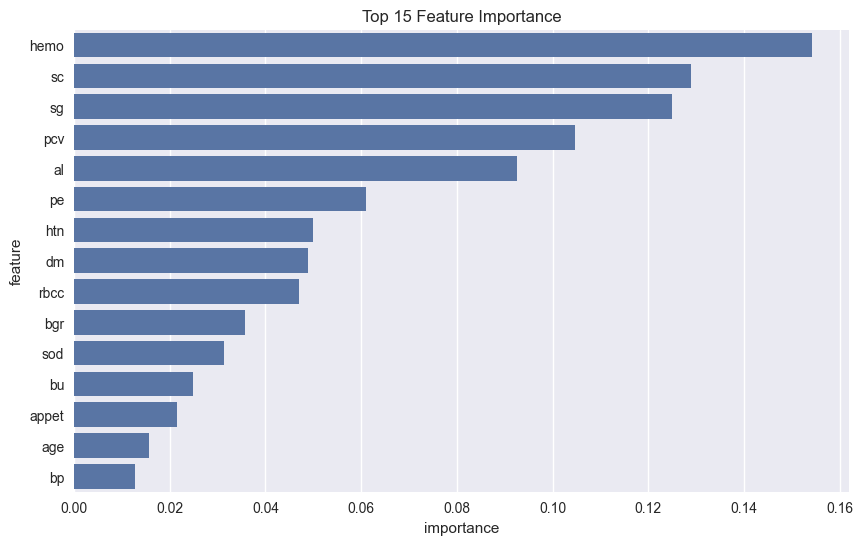

Seleced features (12个): ['sg', 'al', 'bgr', 'bu', 'sc', 'sod', 'hemo', 'pcv', 'rbcc', 'htn', 'dm', 'pe']


In [6]:
print("--- Step 4(2). Feature selection ---")
from sklearn.feature_selection import SelectFromModel

selector_rf = RandomForestClassifier(n_estimators=100, random_state=42)
selector_rf.fit(X_train, y_train)

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': selector_rf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title('Top 15 Feature Importance')
plt.show()

selector = SelectFromModel(selector_rf, threshold='median', prefit=True)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)
selected_features = X.columns[selector.get_support()].tolist()
print(f"Seleced features ({len(selected_features)}个): {selected_features}")

## Step 5. Feature scaling

In [7]:
print("--- Step 5. Feature scaling ---")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

--- Step 5. Feature scaling ---


## Step 6. Handling class imbalance (SMOTE)

In [8]:
print("--- v ---")
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)
print(f"Resampled training set distribution:\n{pd.Series(y_train_res).value_counts()}")

--- v ---
Resampled training set distribution:
class
1    190
0    190
Name: count, dtype: int64


## Step 7. Model training and optimization

In [9]:
print("--- Step 7. Model training and optimization ---")

# 7.1 Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_res, y_train_res)

# 7.2 Random Forest (with grid search)
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5)
rf_grid.fit(X_train_res, y_train_res)
rf_best = rf_grid.best_estimator_

# 7.3 XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train_res, y_train_res)

# 7.4 SVM
svm = SVC(probability=True, random_state=42)
svm.fit(X_train_res, y_train_res)

# 7.5 Ensemble model
ensemble = VotingClassifier(
    estimators=[('lr', lr), ('rf', rf_best), ('xgb', xgb), ('svm', svm)],
    voting='soft'
)
ensemble.fit(X_train_res, y_train_res)

--- Step 7. Model training and optimization ---


VotingClassifier(estimators=[('lr', LogisticRegression(max_iter=1000)),
                             ('rf',
                              RandomForestClassifier(min_samples_split=5,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logl...
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,


## Step 8. Model evaluation

In [10]:
print("--- Step 8. Model evaluation ---")
models = {
    'Logistic Regression': lr,
    'Random Forest': rf_best,
    'XGBoost': xgb,
    'SVM': svm,
    'Ensemble': ensemble
}

best_auc = 0
best_model_name = None
best_model = None

for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    probs = model.predict_proba(X_test_scaled)[:, 1]
    auc = roc_auc_score(y_test, probs)
    
    print(f"\n[{name}]")
    print(f"ROC-AUC: {auc:.4f}")
    print(classification_report(y_test, y_pred))
    
    if auc > best_auc:
        best_auc = auc
        best_model_name = name
        best_model = model

print(f"\n{'='*50}")
print(f"Best model: {best_model_name} (ROC-AUC: {best_auc:.4f})")
print(f"{'='*50}")

--- Step 8. Model evaluation ---

[Logistic Regression]
ROC-AUC: 0.9974
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        33
           1       1.00      0.96      0.98        47

    accuracy                           0.97        80
   macro avg       0.97      0.98      0.97        80
weighted avg       0.98      0.97      0.98        80


[Random Forest]
ROC-AUC: 0.9981
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        33
           1       1.00      0.98      0.99        47

    accuracy                           0.99        80
   macro avg       0.99      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80


[XGBoost]
ROC-AUC: 0.9968
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        33
           1       0.98      0.98      0.98        47

    accuracy                           0.97       

## Step 9. Save the model and all preprocessors

In [11]:
print("--- Step 9. Save the model and all preprocessors ---")

model_data = {
    'model': best_model,
    'model_name': best_model_name,
    'scaler': scaler,
    'selected_features': selected_features
}

joblib.dump(model_data, 'ckd_model_package.pkl')
print(f"Saved best model '{best_model_name}' to 'ckd_model_package.pkl'")

--- Step 9. Save the model and all preprocessors ---
Saved best model 'Random Forest' to 'ckd_model_package.pkl'
